In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [2]:
df = pd.read_excel('./Data/preprocessed_data.xlsx')
print(df.shape)
df.head()

(822, 1017)


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength,kev,type
0,0.535234,0.466639,7.715345,16.533874,19.070876,10.846368,18.110770,19.416752,755.845744,8.849488,...,0.497644,175.159186,0.004928,0.092420,0.023230,1318.852056,0.363279,7.708309,40,Xanthin
1,0.630138,0.365780,3.584026,9.798319,8.271090,9.035690,8.944272,10.846368,130.446981,6.174295,...,0.500935,140.752003,0.023276,0.047875,0.069564,1011.799200,0.856466,16.785011,40,Xanthin
2,0.629451,0.566003,2.355084,4.160901,4.517845,4.237972,4.472136,4.686194,14.701538,2.619083,...,1.000000,35.500000,0.165779,0.150000,0.317460,71.700000,1.017386,10.913313,40,Xanthin
3,0.668485,0.000000,0.000000,4.072370,2.900159,4.517845,4.000000,4.517845,12.367961,2.722318,...,0.571429,6.785714,0.176845,0.257407,0.503597,7.374286,0.248542,3.649770,40,Xanthin
4,0.677339,0.384625,2.285659,5.942564,6.161202,6.040704,6.324555,6.477686,30.103149,4.025132,...,0.678571,22.642857,0.105259,0.128971,0.238052,81.132921,0.480334,6.995504,40,Xanthin


In [3]:
df['kev'].value_counts()

40     137
70     137
100    137
130    137
160    137
190    137
Name: kev, dtype: int64

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Xanthin'),
  Text(1, 0, 'Brushit'),
  Text(2, 0, 'Karbonatapatit'),
  Text(3, 0, 'Cystin'),
  Text(4, 0, 'Struvit'),
  Text(5, 0, 'Harnsäure'),
  Text(6, 0, 'Weddelit')])

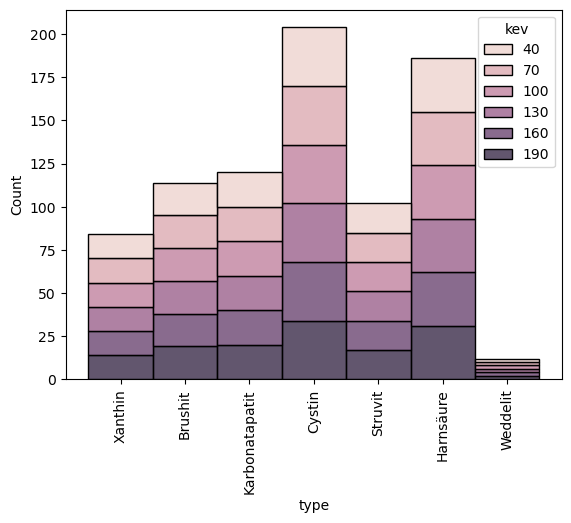

In [4]:
sns.histplot(data=df, x="type", hue="kev", multiple='stack')
plt.xticks(rotation=90)

In [5]:
# Decided to remove "weddelit"

df['type'].value_counts()

Cystin            204
Harnsäure         186
Karbonatapatit    120
Brushit           114
Struvit           102
Xanthin            84
Weddelit           12
Name: type, dtype: int64

In [6]:
print(df.shape)
df = df.drop(df[df['type'] == 'Weddelit'].index)
df.reset_index(inplace=True, drop=True)
df.shape

(822, 1017)


(810, 1017)

In [7]:
# 'Xanthin': 'Xanthine'
# 'Brushit': 'Brushite'
# 'Struvit': 'Struvite'
# 'Harnsäure': 'Uric Acid'
# 'Cystin': 'Cystine'
# 'Karbonatapatit': 'Carbonate Apatite'


In [8]:
df['type'] = df['type'].astype('category')
df['type'] = df['type'].cat.rename_categories({'Xanthin': 'Xanthine',
                                               'Brushit': 'Brushite',
                                               'Struvit': 'Struvite',
                                               'Harnsäure': 'Uric Acid',
                                               'Cystin': 'Cystine',
                                               'Karbonatapatit': 'Carbonate Apatite'})

In [12]:
df['type'][df['kev']==40].value_counts()

Cystine              34
Uric Acid            31
Carbonate Apatite    20
Brushite             19
Struvite             17
Xanthine             14
Name: type, dtype: int64

In [15]:
df['type'][df['kev']==130].value_counts()

Cystine              34
Uric Acid            31
Carbonate Apatite    20
Brushite             19
Struvite             17
Xanthine             14
Name: type, dtype: int64

## Base Model with all kevs

In [9]:
x = df.drop(columns=['type'])
y = df['type'].astype('category')
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x.to_numpy()), columns=x.columns)
x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(x, y, test_size=0.3, stratify=y, random_state=4321)

In [10]:
rfbase = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=10, min_samples_split=2, min_samples_leaf=5, 
                              random_state=12345)
rfbase.fit(x_train_base, y_train_base)
print(rfbase.score(x_train_base, y_train_base), rfbase.score(x_test_base, y_test_base))
y_pred_train_rf_base = rfbase.predict_proba(x_train_base)
y_pred_test_rf_base = rfbase.predict_proba(x_test_base)

0.9894179894179894 0.8148148148148148


In [11]:
y_pred_train_rf_base_vals = rfbase.predict(x_train_base)
y_pred_test_rf_base_vals = rfbase.predict(x_test_base)
print('TRAIN')
print(classification_report(y_train_base, y_pred_train_rf_base_vals))
print('TEST')
print(classification_report(y_test_base, y_pred_test_rf_base_vals)) 

TRAIN
                   precision    recall  f1-score   support

         Brushite       0.99      0.99      0.99        80
Carbonate Apatite       1.00      1.00      1.00        84
          Cystine       1.00      1.00      1.00       143
         Struvite       0.97      0.96      0.96        71
        Uric Acid       0.98      0.98      0.98       130
         Xanthine       1.00      1.00      1.00        59

         accuracy                           0.99       567
        macro avg       0.99      0.99      0.99       567
     weighted avg       0.99      0.99      0.99       567

TEST
                   precision    recall  f1-score   support

         Brushite       0.81      0.76      0.79        34
Carbonate Apatite       0.89      0.69      0.78        36
          Cystine       0.83      0.85      0.84        61
         Struvite       0.75      0.77      0.76        31
        Uric Acid       0.77      0.88      0.82        56
         Xanthine       0.92      0.88   

In [12]:
def plot_feature_importance(importance,names,num,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance[:num])
    feature_names = np.array(names[:num])

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [13]:
features = list(x.columns)

In [14]:
feature_importance = [(feature, round(imp, 6)) for feature, imp in zip(features, rfbase.feature_importances_)]
feature_importance = sorted(feature_importance, key= lambda x: x[1], reverse=True)

In [15]:
features = []
imps = []
for feature, imp in feature_importance:
    features.append(feature)
    imps.append(imp)

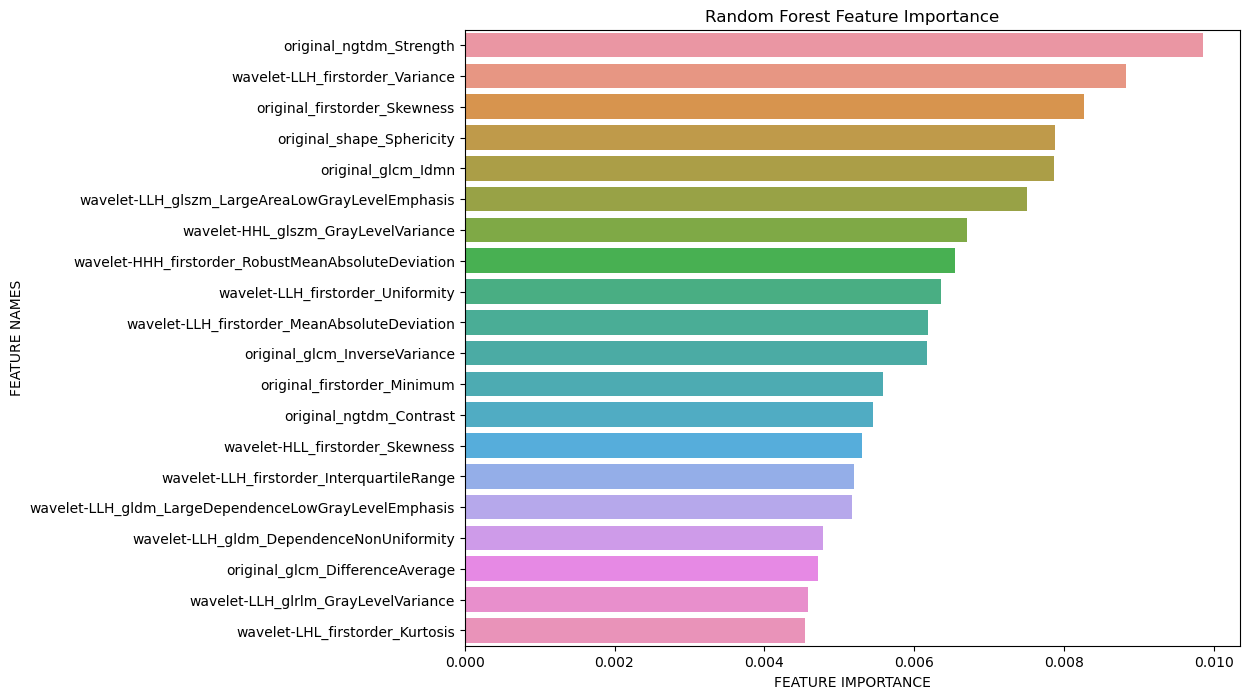

In [16]:
plot_feature_importance(imps, features,20,"Random Forest ")

## For each KeV

In [17]:
def classifier_kev(df, kev):
    df_filtered = df[df['kev']==kev].reset_index(drop=True)
    x = df_filtered.drop(columns=['type'])
    y = df_filtered['type'].astype('category')
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x.to_numpy()), columns=x.columns)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1234)
    model = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=10, min_samples_split=2, min_samples_leaf=5, 
                              random_state=12345)
    model.fit(x_train, y_train)
    print(f'{kev}: Train Acc: {model.score(x_train, y_train)}, Test Acc: {model.score(x_test, y_test)}')
    return (list(y_train), list(y_test), list(model.predict_proba(x_train)), list(model.predict_proba(x_test)))

In [18]:
kevs = [40, 70, 100, 130, 160, 190]
y_true_train_list = []
y_true_test_list = []
y_pred_train_list = []
y_pred_test_list = []
for kev in kevs:
    yttr, ytte, yptr, ypte = classifier_kev(df, kev)
    y_true_train_list.append(yttr)
    y_true_test_list.append(ytte)
    y_pred_train_list.append(yptr)
    y_pred_test_list.append(ypte)
    

40: Train Acc: 0.8829787234042553, Test Acc: 0.4634146341463415
70: Train Acc: 0.925531914893617, Test Acc: 0.4146341463414634
100: Train Acc: 0.8723404255319149, Test Acc: 0.34146341463414637
130: Train Acc: 0.925531914893617, Test Acc: 0.36585365853658536
160: Train Acc: 0.9042553191489362, Test Acc: 0.36585365853658536
190: Train Acc: 0.9468085106382979, Test Acc: 0.3170731707317073


In [19]:

def plot_multi_class_roc(y_true_list, y_scores_list, model_names, phase):
    plt.figure(figsize=(8, 6))
    for y_true, y_scores, model_name in zip(y_true_list, y_scores_list, model_names):
#         if model_name == 'Combined':
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_scores = np.array(y_scores)
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (model_name, roc_auc))
        print(f'DONE: {model_name}')
        
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve in {phase} Phase')
    plt.legend(loc='lower right')
    plt.show()    
    

DONE: 40Kev
DONE: 70Kev
DONE: 100Kev
DONE: 130Kev
DONE: 160Kev
DONE: 190Kev
DONE: Combined


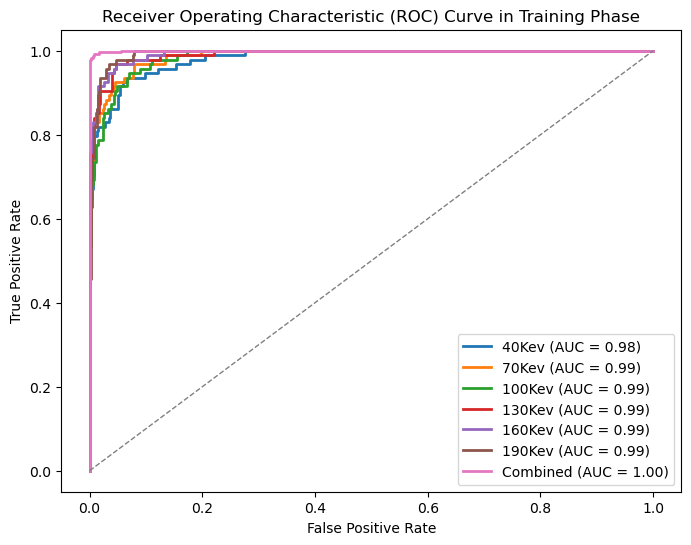

In [20]:
y_true_train_list.append(list(y_train_base))
y_pred_train_list.append(list(y_pred_train_rf_base))
model_names = ['40Kev', '70Kev', '100Kev', '130Kev', '160Kev', '190Kev', 'Combined']
plot_multi_class_roc(y_true_train_list,
                  y_pred_train_list, 
                  model_names, 'Training')

DONE: 40Kev
DONE: 70Kev
DONE: 100Kev
DONE: 130Kev
DONE: 160Kev
DONE: 190Kev
DONE: Combined


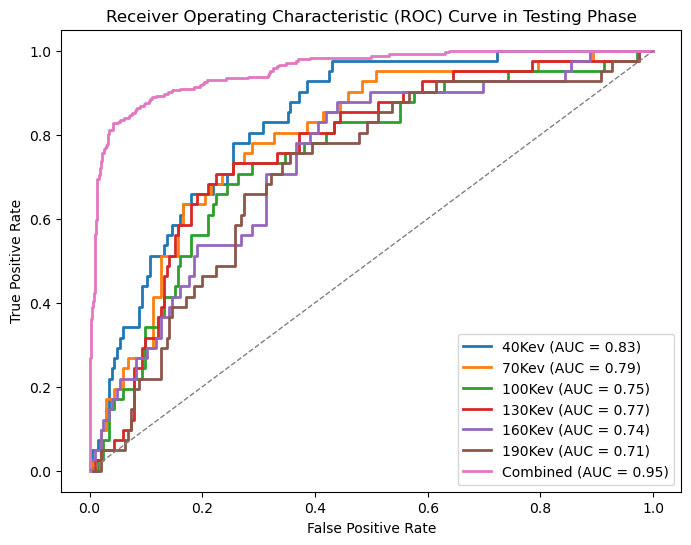

In [21]:
y_true_test_list.append(list(y_test_base))
y_pred_test_list.append(list(y_pred_test_rf_base))
model_names = ['40Kev', '70Kev', '100Kev', '130Kev', '160Kev', '190Kev', 'Combined']
plot_multi_class_roc(y_true_test_list,
                  y_pred_test_list, 
                  model_names, 'Testing')

## New Data

In [22]:
df_new = pd.read_excel('./Data/preprocessed_data_ssl.xlsx')
print(df_new.shape)
df_new.head()

(138, 1016)


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength,type
0,0.535234,0.466639,7.715345,16.533874,19.070876,10.846368,18.110770,19.416752,755.845744,8.849488,...,0.008302,0.510355,217.163439,0.006376,0.086806,0.020065,2445.131547,0.543566,9.024082,Xanthin
1,0.630138,0.365780,3.584026,9.798319,8.271090,9.035690,8.944272,10.846368,130.446981,6.174295,...,0.023740,0.700855,327.332265,0.022577,0.038202,0.059985,2077.629899,1.150517,27.337017,Xanthin
2,0.629451,0.566003,2.355084,4.160901,4.517845,4.237972,4.472136,4.686194,14.701538,2.619083,...,0.226301,0.625000,14.687500,0.158593,0.315315,0.342857,33.666667,0.579948,6.040076,Xanthin
3,0.668485,0.000000,0.000000,4.072370,2.900159,4.517845,4.000000,4.517845,12.367961,2.722318,...,0.446190,0.404762,5.500000,0.221323,0.826667,0.141129,22.471429,4.613411,3.621262,Xanthin
4,0.677339,0.384625,2.285659,5.942564,6.161202,6.040704,6.324555,6.477686,30.103149,4.025132,...,0.100838,0.571429,49.607143,0.084790,0.104992,0.177792,213.813528,1.448777,13.140193,Xanthin


In [23]:
# Decided to remove "weddelit"

df_new['type'].value_counts()

Cystin            34
Harnsäure         31
Karbonatapatit    20
Brushit           19
Struvit           17
Xanthin           14
Weddelit           3
Name: type, dtype: int64

In [24]:
print(df_new.shape)
df_new = df_new.drop(df_new[df_new['type'] == 'Weddelit'].index)
df_new.reset_index(inplace=True, drop=True)
df_new.shape

(138, 1016)


(135, 1016)

In [25]:
df_new['type'] = df_new['type'].astype('category')
df_new['type'] = df_new['type'].cat.rename_categories({'Xanthin': 'Xanthine',
                                               'Brushit': 'Brushite',
                                               'Struvit': 'Struvite',
                                               'Harnsäure': 'Uric Acid',
                                               'Cystin': 'Cystine',
                                               'Karbonatapatit': 'Carbonate Apatite'})

In [26]:
x = df_new.drop(columns=['type'])
y = df_new['type'].astype('category')
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x.to_numpy()), columns=x.columns)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x, y, test_size=0.3, stratify=y, random_state=4321)

In [27]:
rfssl = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=10, min_samples_split=2, min_samples_leaf=5, 
                              random_state=12345)
rfssl.fit(x_train_new, y_train_new)
print(rfssl.score(x_train_new, y_train_new), rfssl.score(x_test_new, y_test_new))
y_pred_train_rf_new = rfssl.predict_proba(x_train_new)
y_pred_test_rf_new = rfssl.predict_proba(x_test_new)

0.851063829787234 0.4634146341463415


DONE: 40Kev
DONE: 70Kev
DONE: 100Kev
DONE: 130Kev
DONE: 160Kev
DONE: 190Kev
DONE: Combined
DONE: SPP


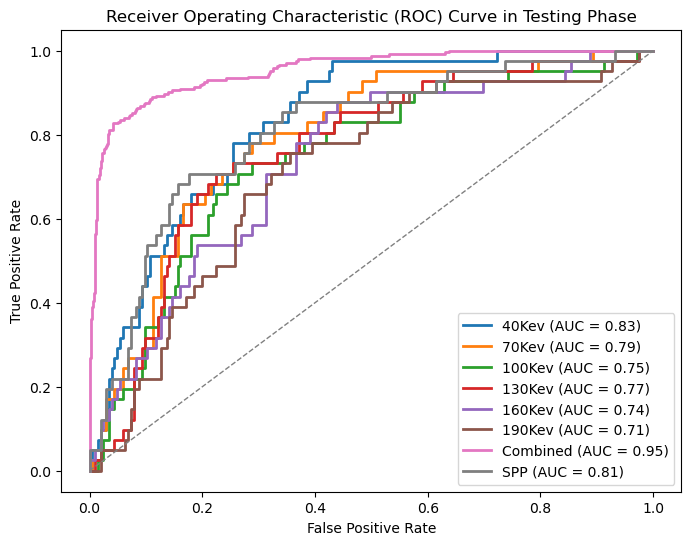

In [28]:
y_true_test_list.append(list(y_test_new))
y_pred_test_list.append(list(y_pred_test_rf_new))
model_names = ['40Kev', '70Kev', '100Kev', '130Kev', '160Kev', '190Kev', 'Combined', 'SPP']
plot_multi_class_roc(y_true_test_list,
                  y_pred_test_list, 
                  model_names, 'Testing')